In [82]:
print('hey')

hey


In [101]:
import glob
import os
from lsst import afw
print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry
import numpy

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.io import fits
from astropy.stats import mad_std
import numpy
%matplotlib inline

20.0.0-4-gde602ef96


In [102]:
# setting up file paths we're looking at, for QE flats
# looking at Raft 13, CCD 21, run 10982 (must be a good run)

superbiaspath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-013/RTM-013-10982-S21_superbias_normal.fits"
superdarkpath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-013/RTM-013-10982-S21_superdark_normal.fits"
qeflatpath = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/*_lambda_flat_*")
qeflatpath.sort()

In [103]:
# use this dataset to make a broadband (combined?) flat (at a certain filter/wavelength) (that mimics the CCOB at certain wavelength), see how qeflatpath is organized
# since ts8 uses narrow band, we average/weight ts8 over broad range of wavelengths to mimic CCOB (bc it has wide beam? bc it goes over more than one raft at a time? bc LED's use a broader band?)
# THIS AVERAGING METHOD ISN'T QUITE ACCURATE, A BIG MATHEMATICAL ISSUE, DOESN'T PERFECTLY ALIGN WITH CCOB ... A BIG PART OF RESEARCH I CAN HELP WITH!

# what is qeflatplath, an imported file??

for i, apath in enumerate(qeflatpath):
    print(i,apath)

# gives us 36 files ... what are each for?? 
# since ts8 uses narrow band, we want to average over 

0 /gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/ITL-3800C-318_lambda_flat_0320_10982_20190518214321.fits
1 /gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/ITL-3800C-318_lambda_flat_0325_10982_20190518214833.fits
2 /gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/ITL-3800C-318_lambda_flat_0350_10982_20190518215337.fits
3 /gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/ITL-3800C-318_lambda_flat_0375_10982_20190518215701.fits
4 /gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/ITL-3800C-318_lambda_flat_0400_10982_20190518215953.fits
5 /gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/ITL-3800C-318_lambda_flat_0425_10982_201905

In [104]:
# Construct an array of wavelengths (numpy) where QE acquistions were made (positions of pixels where their QE was measured?)

wls = numpy.array([ get_ccd_from_id(None, aqeflatpath, []).md.md["MONOWL"] for aqeflatpath in qeflatpath ])

# print array, wavelengths are slightly different than in lines above, no big deal
print(wls)

[ 319.994  324.969  349.982  374.975  400.019  424.965  450.035  475.003
  500.018  525.002  550.029  575.023  599.982  619.997  624.979  650.012
  675.004  700.03   725.012  750.022  774.987  799.976  824.988  850.022
  869.967  875.002  899.999  919.999  925.012  949.965  975.002  999.976
 1025.028 1050.014 1075.002 1099.99 ]


In [105]:
# Let's use SDSS QE for now. Download the QE from the official page. https://www.sdss.org/instruments/camera/ 
# average throughput for all pixels (includes QE, atmosphere, optics, etc.)
# we may have simulated data somewhere for LSST! this is why I am researching our CCOB LED SED's

# Sloan Digital Sky Survey -->  has created the most detailed three-dimensional maps of the Universe ever made, 
# with deep multi-color images of one third of the sky, and spectra for more than three million astronomical objects

!wget -O filter_curves.fits https://www.sdss.org/wp-content/uploads/2017/04/filter_curves.fits

--2020-07-09 21:44:28--  https://www.sdss.org/wp-content/uploads/2017/04/filter_curves.fits
Resolving www.sdss.org (www.sdss.org)... 128.220.233.141
Connecting to www.sdss.org (www.sdss.org)|128.220.233.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34560 (34K) [image/fits]
Saving to: ‘filter_curves.fits’

100%[======================================>] 34,560      --.-K/s   in 0.07s   

2020-07-09 21:44:28 (519 KB/s) - ‘filter_curves.fits’ saved [34560/34560]



SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT The following file is from Jim Gunn, from June 2001.  It should be self-
COMMENT explanatory; for most purposes, you will want to use the second column. 
COMMENT  Consider this file preliminary.                                        
COMMENT                                                                         
COMMENT These filter curves have been used to calculate the effective wavelength
COMMENT s and the qtdl/l (see Chapter 8 of the Black Book) of the filters; the v
COMMENT alues are:                                                              
COMMENT                                                                         
COMMENT u 3551 0.0171       

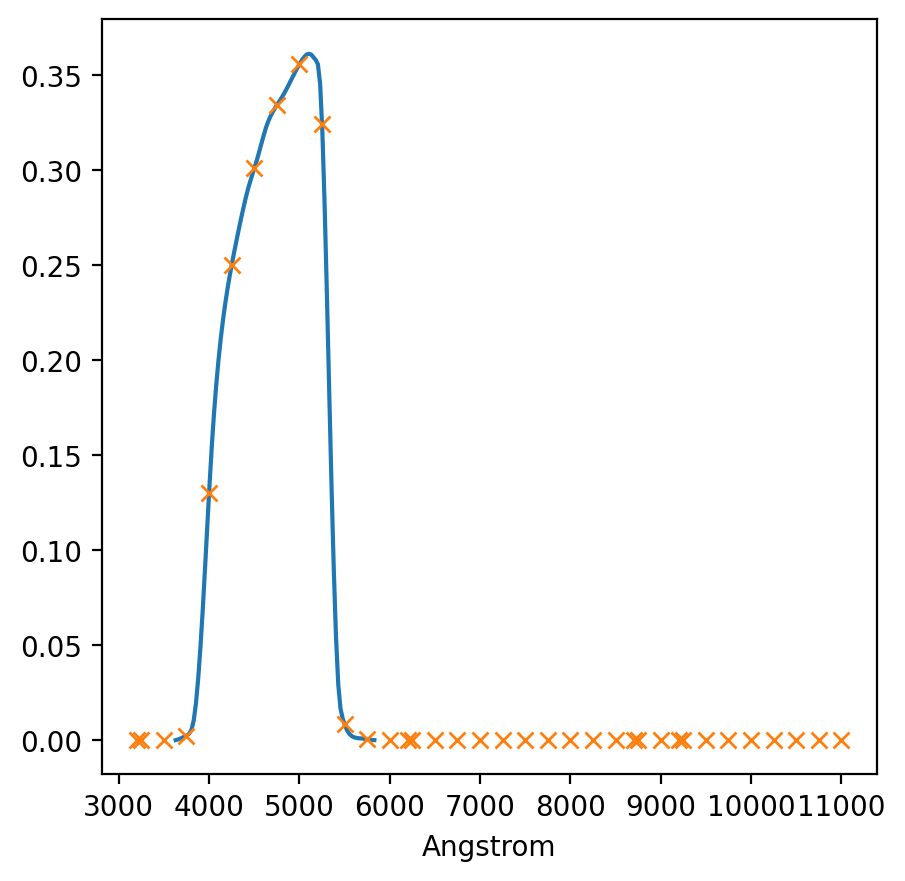

In [106]:
fig, axs = pylab.subplots(figsize=(5,5),dpi=200) 

# [('wavelength', '>f4'), ('respt', '>f4'), ('resbig', '>f4'), ('resnoa', '>f4'), ('xatm', '>f4')]

# QE data from SDSS?  But it says filter?
sdssfilter = fits.open("filter_curves.fits")
# 3 is which filter we're looking at in this data structure that we downloaded
pylab.plot(sdssfilter[2].data["wavelength"],sdssfilter[2].data["respt"])
# calling interpolation function?
weights = numpy.interp(wls*10,sdssfilter[2].data["wavelength"],sdssfilter[2].data["respt"])
pylab.plot(wls*10,weights,"x")
pylab.xlabel("Angstrom")

# can see filters and which number they correspond too, you can see there are 5 
sdssfilter[0].header



Text(0, 0.5, 'Filter Response')

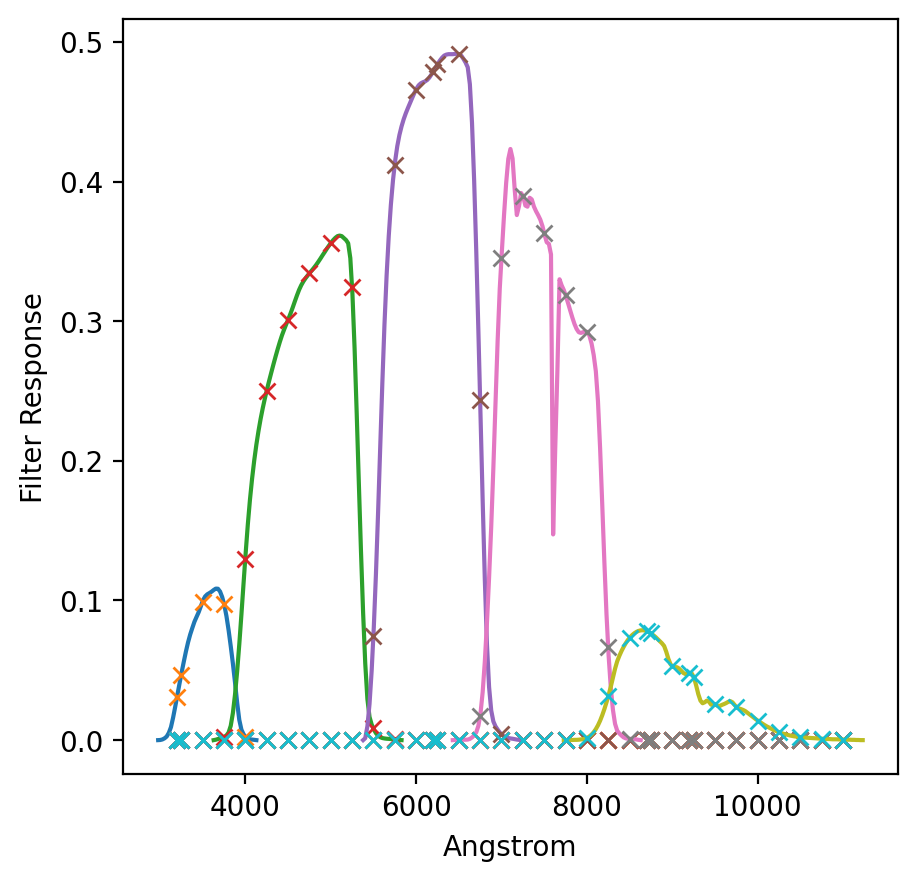

In [107]:
fig, axs = pylab.subplots(figsize=(5,5),dpi=200) 

# [('wavelength', '>f4'), ('respt', '>f4'), ('resbig', '>f4'), ('resnoa', '>f4'), ('xatm', '>f4')]

sdssfilter = fits.open("filter_curves.fits")
# 3 is which filter we're looking at in this data structure that we downloaded
pylab.plot(sdssfilter[1].data["wavelength"],sdssfilter[1].data["respt"])
# calling interpolation function?
weights = numpy.interp(wls*10,sdssfilter[1].data["wavelength"],sdssfilter[1].data["respt"])
pylab.plot(wls*10,weights,"x")

pylab.plot(sdssfilter[2].data["wavelength"],sdssfilter[2].data["respt"])
weights = numpy.interp(wls*10,sdssfilter[2].data["wavelength"],sdssfilter[2].data["respt"])
pylab.plot(wls*10,weights,"x")

pylab.plot(sdssfilter[3].data["wavelength"],sdssfilter[3].data["respt"])
weights = numpy.interp(wls*10,sdssfilter[3].data["wavelength"],sdssfilter[3].data["respt"])
pylab.plot(wls*10,weights,"x")

pylab.plot(sdssfilter[4].data["wavelength"],sdssfilter[4].data["respt"])
weights = numpy.interp(wls*10,sdssfilter[4].data["wavelength"],sdssfilter[4].data["respt"])
pylab.plot(wls*10,weights,"x")

pylab.plot(sdssfilter[5].data["wavelength"],sdssfilter[5].data["respt"])
weights = numpy.interp(wls*10,sdssfilter[5].data["wavelength"],sdssfilter[5].data["respt"])
pylab.plot(wls*10,weights,"x")


pylab.xlabel("Angstrom")
# y label on SDSS plot
pylab.ylabel("Filter Response")

In [108]:
# created the superdarkpath and superbiaspath variables above

superdark = get_ccd_from_id(None, superdarkpath, [])     # load superdark, (but haven't used anywhere)
superbias = get_ccd_from_id(None, superbiaspath, [])     # load superbias

arr = []        # defines an empty array for storing new combined flat
ch = 1          # defines a channel we'll explore in the following:
for i, aqeflatpath in enumerate(qeflatpath):
    aqeflat = get_ccd_from_id(None, aqeflatpath, [], bias_frame=superbias)
    img = aqeflat.unbiased_and_trimmed_image(ch).getImage().array
    arr.append(img*weights[i])

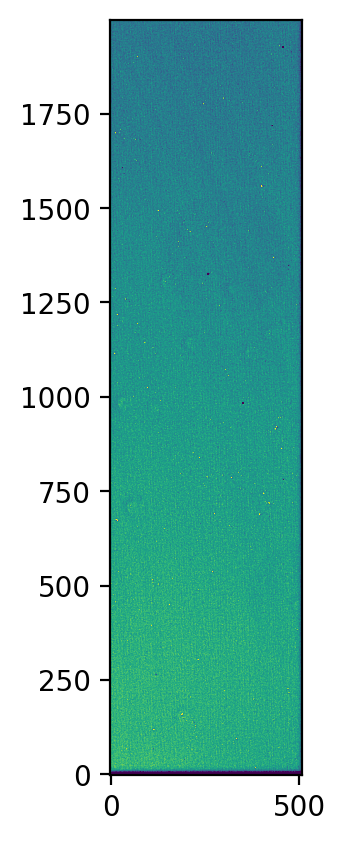

In [109]:
# Let's see how the Combined flat looks
# creating a broadband flat (Combined) from summed up narrow band flats weighted by QE response!!!

fig, axs = pylab.subplots(figsize=(5,5),dpi=200) 
img = numpy.sum(arr,axis=0)/numpy.sum(weights)
mean = img.mean()
std = mad_std(img)
N = 3
pylab.imshow(img,vmin=mean-N*std,vmax=mean+N*std,origin="lower")

# WHAT DO AXES REPRESENT??? change in flux??
    # pixels!! A 2000 x 500 array of pixels, the color corresponds to their flux
    # here we see the coffee stain effect
     #Coffee stain pattern from imperfections in antireflection coating, lose photons if no coating but coating isn't uniform.

In [110]:
fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-211.815_-0.395.fits"
ccob_red = get_ccd_from_id(None, fname, [])
print ( mad_std(get_data_as_read(ccob_red,ch,["imaging"])["imaging"]))
fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_uv_-211.815_-0.395.fits"
ccob_blue = get_ccd_from_id(None, fname, [])
print ( mad_std(get_data_as_read(ccob_blue,ch,["imaging"])["imaging"]))

# normalize flat 
red = get_data_as_read(ccob_red,ch,["imaging"])["imaging"]
blue = get_data_as_read(ccob_blue,ch,["imaging"])["imaging"]

# changed this normalization to blue!!
normedimg = img/img.mean()*blue.mean()

464.05449439225345
431.4372455851302


360.4576643741745
431.4372455851302
0.006227848005393069


"\nFrom Yousuke's SLAC announcement/analysis:\n\nI have spent some time to generate a broad band flat image from narrow band flat images. \nI haven’t had a concrete idea to do this, but I have just begun simply summing up narrow band flats weighted by QE response. \nHere I used SDSS r band filter response as a starting point. At wavelengths where QE acquisitions were made, \nI simply took QE numbers by interpolating the response function (The first panel shows how they were sampled). \nThen sum up all flat images weighting by these QE numbers to generate a combined flat image.\nThe second panel shows two dimensional image of the combined flat, CCOB Red flat, and a differential ratio of them.\nThe third panel shows histograms of the differential ratios from several different flats. Here I took CCOB flat as a reference, \nand then each flat denoted in the legend is examined. Combined has the tallest peak, while others range at the same level. \nInterestingly, a narrow band image at 620nm

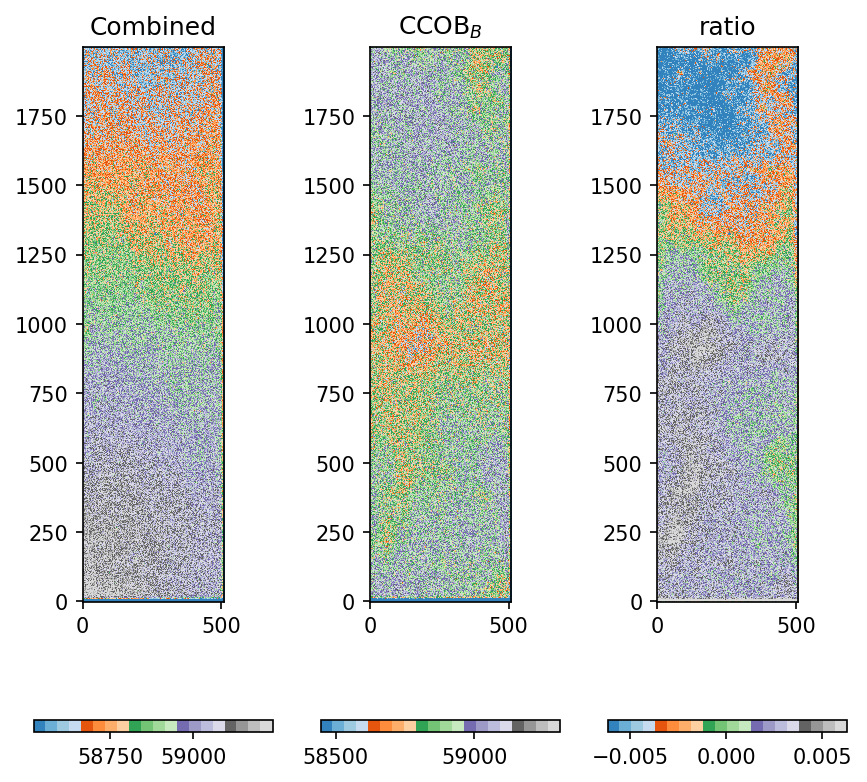

In [111]:
# change so CCOB B is displayed intstead of R

fig, axs = pylab.subplots(1,3,figsize=(7,7),dpi=150) 
for ax, animg, label in zip(axs,[normedimg, blue, (normedimg-blue)/blue], ["Combined",r"CCOB$_{B}$","ratio"]):
    mean = numpy.median(animg)
    std = mad_std(animg)
    N = 1
    ax.set_title(label)
    im = ax.imshow(animg,vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))
    fig.colorbar( im, ax=ax, orientation="horizontal")
    print(std)
    
    
"""
From Yousuke's SLAC announcement/analysis:

I have spent some time to generate a broad band flat image from narrow band flat images. 
I haven’t had a concrete idea to do this, but I have just begun simply summing up narrow band flats weighted by QE response. 
Here I used SDSS r band filter response as a starting point. At wavelengths where QE acquisitions were made, 
I simply took QE numbers by interpolating the response function (The first panel shows how they were sampled). 
Then sum up all flat images weighting by these QE numbers to generate a combined flat image.
The second panel shows two dimensional image of the combined flat, CCOB Red flat, and a differential ratio of them.
The third panel shows histograms of the differential ratios from several different flats. Here I took CCOB flat as a reference, 
and then each flat denoted in the legend is examined. Combined has the tallest peak, while others range at the same level. 
Interestingly, a narrow band image at 620nm and CCOB Blue look similar. I thought CCOB blue would be a worst case and a 
narrow band image at 620nm would be closer to the Combined one but the only Combined one had the distinct distribution, 
which says the QE of the combined one looks similar to the CCOB Red than others. 

"""

485.447981092096
464.05449439225345
0.006003453156509916


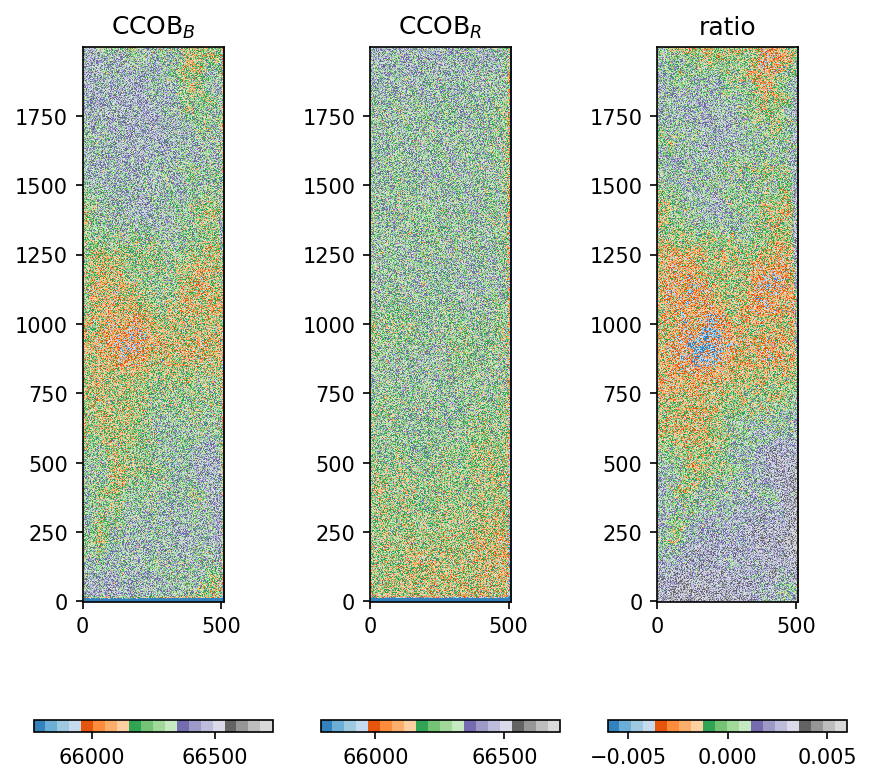

In [112]:
# What happens if comparing red and blue? It is noisy but some structure can be seen in the ratio panel.

# DIDN'T CHANGE ANY CODE

fig, axs = pylab.subplots(1,3,figsize=(7,7),dpi=150)
normedblue = blue/blue.mean()*red.mean()
for ax, animg, label in zip(axs,[normedblue, red, (normedblue-red)/red], [r"CCOB$_{B}$",r"CCOB$_{R}$","ratio"]):
    mean = numpy.median(animg)
    std = mad_std(animg)
    N = 1
    ax.set_title(label)
    im = ax.imshow(animg,vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))
    fig.colorbar( im, ax=ax, orientation="horizontal")
    print(std)

In [113]:
# Noise depends on flux levels. We'll pick a flat pairs at the same flux level we are exploring by calculating mean for all flat pairs.

flatpairs = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/flat_pair_raft_acq/v0/85183/S21/ITL-3800C-318_flat_*_flat?*.fits")
flatpairs.sort()
for i, aflatpair in enumerate(flatpairs):
    aqeflat = get_ccd_from_id(None, aflatpair, [], bias_frame=superbias)
    img = aqeflat.unbiased_and_trimmed_image(ch).getImage().array
    print("{:02d}   {}   {:05f}".format(i, os.path.basename(aflatpair), img.mean()))
    

# flat 1 and 2 pairs had same exposure time and thus same flux level, use comparison of flats to see (noise?)fluctuation (not necessarily of photons, but ideally, bc that noise is easier to correct for and detect?)

00   ITL-3800C-318_flat_0000.46s_flat1_10982_20190518181820.fits   96.660767
01   ITL-3800C-318_flat_0000.46s_flat2_10982_20190518181854.fits   99.103783
02   ITL-3800C-318_flat_0000.60s_flat1_10982_20190518181934.fits   133.241119
03   ITL-3800C-318_flat_0000.60s_flat2_10982_20190518181952.fits   134.069016
04   ITL-3800C-318_flat_0000.83s_flat1_10982_20190518182017.fits   184.084671
05   ITL-3800C-318_flat_0000.83s_flat2_10982_20190518182036.fits   187.658585
06   ITL-3800C-318_flat_0001.11s_flat1_10982_20190518182101.fits   249.398544
07   ITL-3800C-318_flat_0001.11s_flat2_10982_20190518182120.fits   249.092651
08   ITL-3800C-318_flat_0001.48s_flat1_10982_20190518182147.fits   333.594086
09   ITL-3800C-318_flat_0001.48s_flat2_10982_20190518182207.fits   338.782928
10   ITL-3800C-318_flat_0001.89s_flat1_10982_20190518182450.fits   983.985352
11   ITL-3800C-318_flat_0001.89s_flat2_10982_20190518182512.fits   981.403625
12   ITL-3800C-318_flat_0002.46s_flat1_10982_20190518182541.fits  

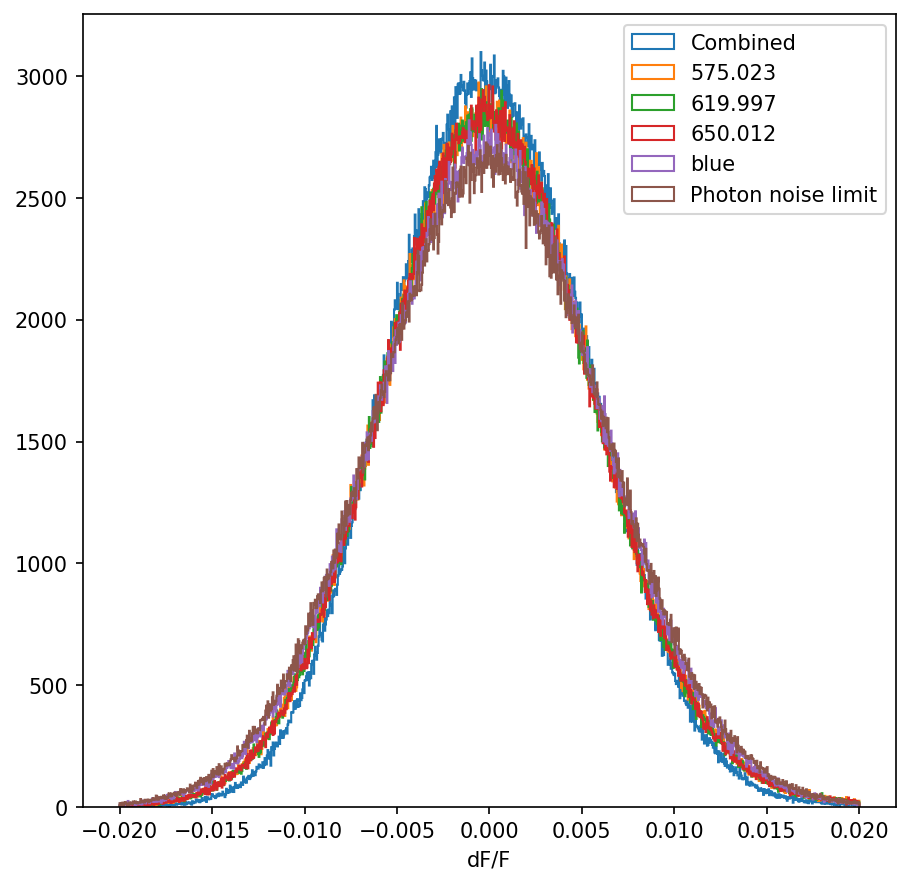

In [114]:
fig, axs = pylab.subplots(1,1,figsize=(7,7),dpi=150)

def getonewl( num ):
    fname = qeflatpath[num]
    ccd_particular = get_ccd_from_id(None, fname, [])
    particular = get_data_as_read(ccd_particular,ch,["imaging"])["imaging"]
    normedparticular = particular/particular.mean()*red.mean()
    return normedparticular.flatten(),  ccd_particular.md.md["MONOWL"]

for anarray, label in [
            ( normedimg.flatten(), "Combined" ),
            getonewl(11),
            getonewl(13),
            getonewl(15),
            ( normedblue.flatten(), "blue" ),
#            ( red.mean(), r"$\langle {\rm red}\rangle$-red" )    
    ]:
    arr = (anarray-red.flatten())/red.flatten()
    pylab.hist(arr-numpy.median(arr),
               bins=1000,range=(-0.02,0.02),histtype="step",label=label)
#30,31   #20k
#52,53   #60k
#76,77
a=get_ccd_from_id(None, flatpairs[30], [], bias_frame=superbias).unbiased_and_trimmed_image(ch).getImage().array # one of flat pairs which have almost same flux level as R. (~20k)
b=get_ccd_from_id(None, flatpairs[31], [], bias_frame=superbias).unbiased_and_trimmed_image(ch).getImage().array
rand = ( a-b ).flatten()/(b.flatten())/numpy.sqrt(2)
pylab.hist(
    rand-numpy.median(rand),
    bins=1000,range=(-0.02,0.02),histtype="step",label="Photon noise limit"
)
pylab.xlabel("dF/F")
pylab.legend()

In [115]:
from scipy.ndimage import gaussian_filter

360.4576643741745
431.4372455851302
0.006227848005393069


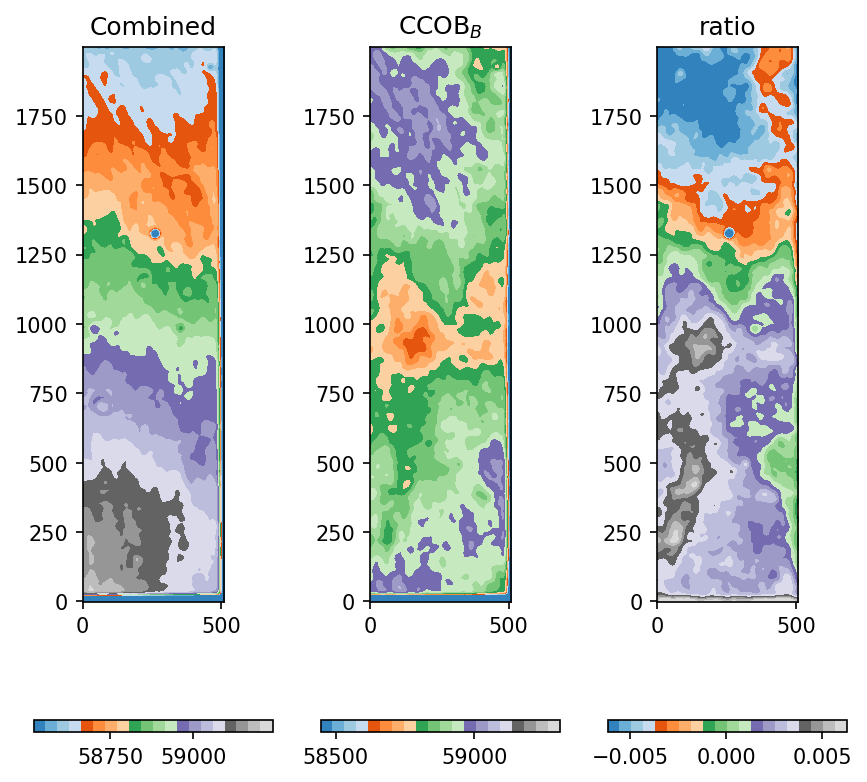

In [116]:
sigma=10
N = 1

fig, axs = pylab.subplots(1,3,figsize=(7,7),dpi=150) 
for ax, animg, label in zip(axs,[normedimg, blue, (normedimg-blue)/blue], ["Combined",r"CCOB$_{B}$","ratio"]):
    mean = numpy.median(animg)
    std = mad_std(animg)
    ax.set_title(label)
    im = ax.imshow(gaussian_filter(animg,sigma=sigma),vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))
    fig.colorbar( im, ax=ax, orientation="horizontal")
    print(std)

In [117]:
# didn't change any code, comparing CCOBb vs. CCOBr
# already in Yousuke's notebook

'''
fig, axs = pylab.subplots(1,3,figsize=(7,7),dpi=150)
normedblue = blue/blue.mean()*red.mean()
for ax, animg, label in zip(axs,[normedblue, red, (normedblue-red)/red], [r"CCOB$_{B}$",r"CCOB$_{R}$","ratio"]):
    mean = numpy.median(animg)
    std = mad_std(animg)
    ax.set_title(label)
    im = ax.imshow(gaussian_filter(animg,sigma=sigma),vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))
    fig.colorbar( im, ax=ax, orientation="horizontal")
    print(std)
'''

'\nfig, axs = pylab.subplots(1,3,figsize=(7,7),dpi=150)\nnormedblue = blue/blue.mean()*red.mean()\nfor ax, animg, label in zip(axs,[normedblue, red, (normedblue-red)/red], [r"CCOB$_{B}$",r"CCOB$_{R}$","ratio"]):\n    mean = numpy.median(animg)\n    std = mad_std(animg)\n    ax.set_title(label)\n    im = ax.imshow(gaussian_filter(animg,sigma=sigma),vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))\n    fig.colorbar( im, ax=ax, orientation="horizontal")\n    print(std)\n'

In [ ]:

from scipy import signal


fig, axs = pylab.subplots(1,1,figsize=(7,7),dpi=150)

range = (-0.007,0.007)
nbins = 1000
for anarray, label in [
            ( normedblue.flatten(), "blue" ),
#            ( normedimg.flatten(), "Combined" ),
            getonewl(11),
            getonewl(13),
            getonewl(15),
            ( normedimg.flatten(), "Combined" ),    
#            ( red.mean(), r"$\langle {\rm red}\rangle$-red" )    
    ]:
    arr = gaussian_filter(anarray-red.flatten(),sigma=sigma)/red.flatten()
    s = mad_std(arr)
    print("{:.2}%".format(s*100))    
    pylab.hist(arr-numpy.median(arr),
               bins=nbins,range=range,histtype="step",label=label)
dx= (range[-1]-range[0])/nbins
x = numpy.arange(*range,dx)
s = mad_std(arr)
y = numpy.exp(-x**2/(2*s**2))/numpy.sqrt(2*numpy.pi*s**2)*dx*arr.shape[0]
print("{:.2}%".format(s*100))
pylab.plot(x,y)
pylab.xlabel("dF/F")
pylab.legend()